In [96]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#Loading training set into dataframe
df = pd.read_excel('C:\\Users\\Administrator\\Desktop\zheng_toc_train.xlsx')
df.head()

,RT,DEN,AC,GR,TOC
0,2.101,2.483,98.687,70.315,1.44
1,2.793,2.504,89.706,66.399,1.45
2,3.225,2.490,89.871,63.177,1.64
3,1.580,2.503,96.431,69.392,1.77
4,2.064,2.538,96.745,61.399,1.87


In [3]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [4]:
#Normalizing dataset
new_df = normalize(df,df.columns)
new_df

,RT,DEN,AC,GR,TOC
0,0.001044,0.625610,0.525138,0.158498,0.048847
1,0.001510,0.651220,0.421908,0.147142,0.049186
2,0.001801,0.634146,0.423805,0.137798,0.055631
3,0.000694,0.650000,0.499207,0.155822,0.060041
4,0.001019,0.692683,0.502816,0.132642,0.063433
...,...,...,...,...,...
277,0.443530,0.207317,0.623678,0.899284,0.453867
278,0.196818,0.621951,0.424368,0.622655,0.484057
279,0.623690,0.060976,0.644943,0.998202,0.751696
280,0.048124,0.743902,0.312874,0.444828,0.160787


In [5]:
#This is an example, taking TOC as label to predict
label = new_df['TOC']
train = new_df.drop('TOC', axis=1) # we don't need it in this project
label.shape, train.shape

((282,), (282, 4))

In [6]:
label.isnull().values.any()
train.isnull().values.any()

False

In [7]:
#Test Nan and fill with mean
for column in list(train.columns[train.isnull().sum() > 0]):
    mean_val = train[column].mean()
    train[column].fillna(mean_val, inplace=True)

In [8]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=42)
kfold.get_n_splits(train)

6

In [9]:
train = np.array(train)
label = np.array(label)

In [10]:
train = torch.tensor(train, dtype=torch.float32)
label = torch.tensor(label, dtype=torch.float32)

In [11]:
label.shape, train.shape

(torch.Size([282]), torch.Size([282, 4]))

In [12]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [80]:
class PasseyNet_mlp(nn.Module):
    def __init__(self, input_size):
        super(PasseyNet_mlp, self).__init__()
        self.fc0 = nn.Linear(4, 282)  # 282X282
        self.fc1 = nn.Linear(282, 64)  # 282X64
        self.fc2 = nn.Linear(64, 4)  # 282X4
        self.fc3 = nn.Linear(4, 1)  # 282X1
        
    def forward(self, x):
        well_log_matrix = F.relu(self.fc0(x))
        well_log_matrix = F.relu(self.fc1(well_log_matrix))
        well_log_matrix = F.relu(self.fc2(well_log_matrix))
        
        RO_matrix = F.relu(self.fc0(x))
        RO_matrix = F.relu(self.fc1(RO_matrix))
        RO_matrix = F.relu(self.fc2(RO_matrix))
        RO_matrix = F.relu(self.fc3(RO_matrix))
        
        Bias_matrix = F.relu(self.fc0(x))
        Bias_matrix = F.relu(self.fc1(Bias_matrix))
        Bias_matrix = F.relu(self.fc2(Bias_matrix))
        Bias_matrix = F.relu(self.fc3(Bias_matrix))
        
        output =  torch.matmul(torch.matmul(x, well_log_matrix.T),torch.pow(10.0,RO_matrix))+Bias_matrix
        
        return output  

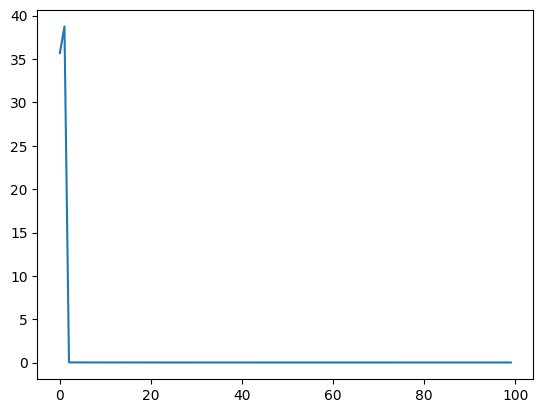

In [100]:
model = PasseyNet_mlp(input_size=282)  # 输入大小为282
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
loss_list = []

for epoch in range(100):  
    output = model(train)
    y_pred = []
    for i in range(len(output)):
        y_pred.append(output[i])  
    y_pred = torch.stack(y_pred).view(282)
    loss = criterion(y_pred, label)
    loss_list.append(loss.item())
    
    optimizer.zero_grad()   
    loss.backward()           
    optimizer.step()

plt.plot(loss_list) 
plt.show()